# Analyse de la Ségrégation dans les Aires Urbaines

Ce notebook permet d'analyser la relation entre la taille des aires urbaines et le niveau de ségrégation en utilisant les fichiers téléchargés depuis l'INSEE. 

Les fichiers (CSV et XLSX) doivent être placés dans le dossier `inputs/` (par exemple, le fichier décompressé `fonds_aav2020_2024.zip`).
Les résultats (graphes, tableaux) seront sauvegardés dans le dossier `outputs/`.

Nous réaliserons notamment une conversion XLSX->CSV (si nécessaire), un nettoyage des données, un calcul d'indicateur (ratio de minorité) et une régression linéaire par moindres carrés.

Enfin, s'il existe des données géographiques, une carte pourra être réalisée pour visualiser spatialement la ségrégation.

## Extraction des fichiers ZIP et Conversion XLSX -> CSV

Si vous avez des fichiers compressés (ZIP) ou des fichiers XLSX dans `inputs/`, nous pouvons les convertir en CSV pour simplifier l'analyse.

Attention : cette étape n'est nécessaire que si vous n'avez pas déjà extrait ou converti vos fichiers.

In [4]:
import os
import glob
import zipfile
import pandas as pd

input_dir = os.path.join('..', 'inputs/csv')

# Extraction des fichiers ZIP (si présents)
zip_files = glob.glob(os.path.join(input_dir, '*.zip'))
for z in zip_files:
    print(f"Extraction de {os.path.basename(z)}...")
    with zipfile.ZipFile(z, 'r') as zip_ref:
        zip_ref.extractall(input_dir)

print("Extraction terminée.")

# Conversion des fichiers XLSX en CSV (si présents)
xlsx_files = glob.glob(os.path.join(input_dir, '*.xlsx'))
for x in xlsx_files:
    print(f"Conversion de {os.path.basename(x)} en CSV...")
    try:
        # Supprime les 5 premières lignes en utilisant skiprows
        df = pd.read_excel(x, skiprows=5)
        csv_filename = os.path.splitext(os.path.basename(x))[0] + '.csv'
        df.to_csv(os.path.join(input_dir, csv_filename), index=False, sep=';')
        print(f"Fichier {csv_filename} créé.")
    except Exception as e:
        print(f"Erreur lors de la conversion de {x}: {e}")

print("Conversion XLSX -> CSV terminée.")

Extraction terminée.
Conversion de AAV2020_au_01-01-2024.xlsx en CSV...
Erreur lors de la conversion de ..\inputs/csv\AAV2020_au_01-01-2024.xlsx: Missing optional dependency 'openpyxl'.  Use pip or conda to install openpyxl.
Conversion XLSX -> CSV terminée.


## Chargement des Données

Nous allons lister et charger tous les fichiers CSV présents dans le dossier `inputs/`.

In [5]:
import matplotlib.pyplot as plt

# Définition du dossier outputs
output_dir = os.path.join('..', 'outputs')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Liste de tous les fichiers CSV dans le dossier inputs
csv_files = glob.glob(os.path.join(input_dir, '*.csv'))

if not csv_files:
    print("Aucun fichier CSV trouvé dans le dossier inputs. Vérifiez vos téléchargements depuis l'INSEE.")
else:
    print(f"{len(csv_files)} fichier(s) CSV trouvé(s) :")
    for file in csv_files:
        print(os.path.basename(file))

# Chargement de tous les fichiers dans une liste de DataFrames
dataframes = []
for file in csv_files:
    try:
        # On suppose que le séparateur est ';'. Adaptez si nécessaire.
        df = pd.read_csv(file, sep=';', encoding='utf-8', low_memory=False)
    except Exception as e:
        print(f"Erreur lors du chargement de {file}: {e}")
        continue
    df['source_file'] = os.path.basename(file)  # Pour identifier la provenance
    dataframes.append(df)

# Concaténer tous les DataFrames en un seul
if dataframes:
    full_data = pd.concat(dataframes, ignore_index=True)
    print("Données combinées :")
    display(full_data.head())
else:
    print("Aucune donnée chargée.")

1 fichier(s) CSV trouvé(s) :
AAV2020_au_01-01-2024.csv
Données combinées :


,AAV2020,LIBAAV2020,TAAV2017,TDAAV2017,NB_COM,source_file
0,000,Commune hors attraction des villes,0,0,8921,AAV2020_au_01-01-2024.csv
1,001,Paris,5,50,1929,AAV2020_au_01-01-2024.csv
2,002,Lyon,4,42,397,AAV2020_au_01-01-2024.csv
3,003,Marseille - Aix-en-Provence,4,42,115,AAV2020_au_01-01-2024.csv
4,004,Lille (partie française),4,42,201,AAV2020_au_01-01-2024.csv


## Préparation et Nettoyage des Données

Dans cette section, nous nettoyons et préparons les données. Ici, un exemple de nettoyage consiste à supprimer les lignes dont la colonne `AAV2020` vaut "000" et à renommer certaines colonnes pour faciliter l'analyse.

Adaptez les noms des colonnes en fonction de la structure réelle de vos fichiers.

In [7]:
# Exemple de nettoyage avec suppression des outliers dans total_population
if 'full_data' in globals():
    # Suppression des lignes où 'AAV2020' vaut "000" et des valeurs manquantes
    data_clean = full_data[full_data["AAV2020"] != "000"].dropna()
    
    # Renommage de colonnes (exemple) :
    # - 'TAAV2017' est considéré comme la population du groupe minoritaire
    # - 'NB_COM' est considéré comme la population totale de l'aire urbaine
    data_clean = data_clean.rename(columns={
        'TAAV2017': 'groupe_minority',
        'NB_COM': 'total_population'
    })
    
    # Suppression des données trop extrêmes dans total_population
    q_low, q_hi = data_clean['total_population'].quantile([0.01, 0.99])
    data_clean = data_clean[(data_clean['total_population'] >= q_low) & (data_clean['total_population'] <= q_hi)]
    
    print("Données nettoyées :")
    display(data_clean.head())
else:
    print("Aucune donnée à nettoyer.")

Données nettoyées :


,AAV2020,LIBAAV2020,groupe_minority,TDAAV2017,total_population,source_file
3,003,Marseille - Aix-en-Provence,4,42,115,AAV2020_au_01-01-2024.csv
4,004,Lille (partie française),4,42,201,AAV2020_au_01-01-2024.csv
6,006,Bordeaux,4,42,275,AAV2020_au_01-01-2024.csv
7,008,Nantes,4,41,116,AAV2020_au_01-01-2024.csv
8,010,Strasbourg (partie française),4,41,268,AAV2020_au_01-01-2024.csv


## Calcul des Indicateurs de Ségrégation

Nous allons calculer un indicateur simple : le ratio de la population minoritaire par rapport à la population totale. 

Assurez-vous que les colonnes `groupe_minority` et `total_population` existent et contiennent des valeurs numériques.

In [8]:
if 'data_clean' in globals():
    # Conversion des colonnes en numérique
    data_clean['groupe_minority'] = pd.to_numeric(data_clean['groupe_minority'], errors='coerce')
    data_clean['total_population'] = pd.to_numeric(data_clean['total_population'], errors='coerce')
    
    # Suppression des lignes où total_population est nul ou NaN pour éviter la division par zéro
    data_clean = data_clean.dropna(subset=['groupe_minority', 'total_population'])
    data_clean = data_clean[data_clean['total_population'] != 0]
    
    # Calcul du ratio minorité
    data_clean['minority_ratio'] = data_clean['groupe_minority'] / data_clean['total_population']
    print("Indice de ségrégation (ratio minorité) calculé :")
    display(data_clean[['minority_ratio']].head())
else:
    print("Aucune donnée nettoyée pour l'analyse.")

Indice de ségrégation (ratio minorité) calculé :


,minority_ratio
3,0.034783
4,0.019900
6,0.014545
7,0.034483
8,0.014925


## Régression Linéaire par Moindres Carrés

Nous allons analyser la relation entre la taille de l'aire urbaine (que nous supposerons être mesurée par `total_population`) et le niveau de ségrégation (ici le `minority_ratio`). 

La régression linéaire nous permettra d'évaluer si les aires urbaines de plus grande taille sont plus (ou moins) ségréguées.

Nous utiliserons `statsmodels` pour cette régression.

                            OLS Regression Results                            
Dep. Variable:         minority_ratio   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     108.6
Date:                Sun, 16 Mar 2025   Prob (F-statistic):           1.05e-23
Time:                        13:40:34   Log-Likelihood:                -107.31
No. Observations:                 692   AIC:                             218.6
Df Residuals:                     690   BIC:                             227.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.2785      0.013  

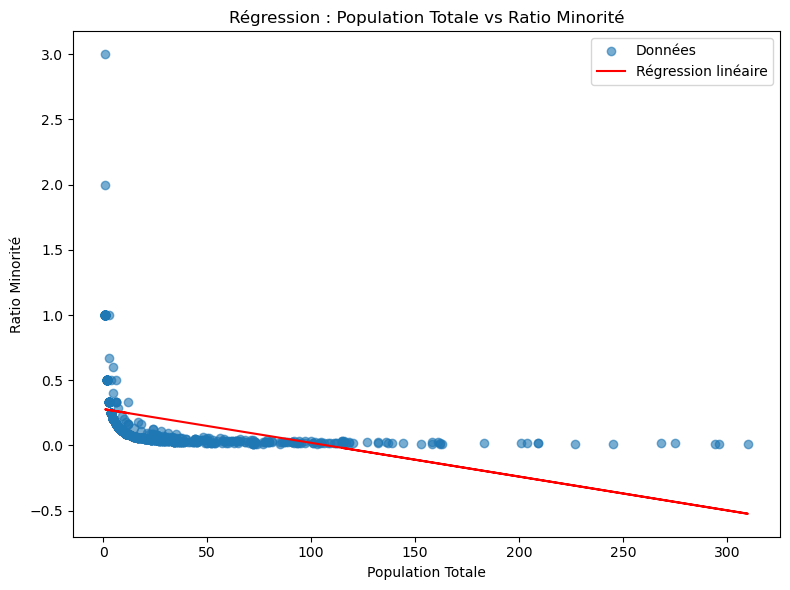

In [9]:
import statsmodels.api as sm

if 'data_clean' in globals() and 'total_population' in data_clean.columns and 'minority_ratio' in data_clean.columns:
    # Définir les variables dépendante et indépendante
    X = data_clean['total_population']
    y = data_clean['minority_ratio']
    
    # Ajouter une constante pour l'ordonnée à l'origine
    X = sm.add_constant(X)
    
    # Régression linéaire
    model = sm.OLS(y, X).fit()
    print(model.summary())
    
    # Visualisation de la régression
    plt.figure(figsize=(8, 6))
    plt.scatter(data_clean['total_population'], data_clean['minority_ratio'], label='Données', alpha=0.6)
    
    # Prédiction avec le modèle
    predictions = model.predict(X)
    plt.plot(data_clean['total_population'], predictions, color='red', label='Régression linéaire')
    
    plt.xlabel('Population Totale')
    plt.ylabel('Ratio Minorité')
    plt.title('Régression : Population Totale vs Ratio Minorité')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'regression_population_vs_ratio.png'))
    plt.show()
else:
    print("Données insuffisantes pour effectuer la régression linéaire.")

## Visualisation Cartographique (Optionnel)

Si vos données comportent des informations géographiques (par exemple, coordonnées, codes INSEE permettant de les joindre à une carte), vous pouvez réaliser une carte de la ségrégation.

Cette section est optionnelle et suppose que vous avez une colonne (par exemple, `geometry`) ou que vous utilisez un shapefile associé aux aires urbaines.

Vous pouvez utiliser `geopandas` pour cette étape.

In [22]:
try:
    import os
    import geopandas as gpd
    import folium
    import pandas as pd

    # Chemin vers le shapefile
    shapefile_path = os.path.join('..', 'inputs', 'carte', 'aav2020_2024', 'aav2020_2024.shp')
    
    if os.path.exists(shapefile_path):
        # Lecture du shapefile
        gdf = gpd.read_file(shapefile_path)
        
        # Fusionner gdf avec data_clean sur la clé ('aav2020' dans gdf et 'AAV2020' dans data_clean)
        merged = gdf.merge(data_clean, left_on='aav2020', right_on='AAV2020', how='left')
        
        # Assurer que 'minority_ratio' est numérique
        merged['minority_ratio'] = pd.to_numeric(merged['minority_ratio'], errors='coerce')
        
        # Calcul du centre de la carte à partir des centroïdes
        merged['centroid'] = merged.geometry.centroid
        center_lat = merged['centroid'].y.mean()
        center_lon = merged['centroid'].x.mean()
        
        # Supprimer la colonne 'centroid' qui cause l'erreur JSON serializable
        merged_clean = merged.drop(columns=['centroid'])
        
        # Création de la carte interactive
        m = folium.Map(location=[center_lat, center_lon], zoom_start=8, tiles='cartodbpositron')
        
        # Ajout d'une couche Choropleth pour afficher le ratio minorité
        folium.Choropleth(
            geo_data=merged_clean,
            name='Choroplèthe',
            data=merged_clean,
            columns=['aav2020', 'minority_ratio'],
            key_on='feature.properties.aav2020',
            fill_color='YlOrRd',
            fill_opacity=0.7,
            line_opacity=0.2,
            legend_name='Ratio Minorité'
        ).add_to(m)
        
        folium.LayerControl().add_to(m)
        
        # Sauvegarde de la carte interactive en HTML
        output_dir = os.path.join('..', 'outputs')
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        map_path = os.path.join(output_dir, 'carte_interactive_ratio_minority.html')
        m.save(map_path)
        print("Carte interactive sauvegardée sous :", map_path)
        
        # Pour l'afficher directement dans un Notebook
        m
    else:
        print("Aucun fichier shapefile trouvé dans le chemin spécifié pour la cartographie.")
except ImportError:
    print("Assurez-vous d'avoir installé geopandas et folium avec 'pip install geopandas folium'.")


C:\Users\X515\AppData\Local\Temp\ipykernel_11248\4017809690.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged['centroid'] = merged.geometry.centroid


Carte interactive sauvegardée sous : ..\outputs\carte_interactive_ratio_minority.html


## Sauvegarde et Export des Résultats

Tous les graphiques et résultats sont sauvegardés dans le dossier `outputs/`.

Adaptez les chemins et noms de fichiers si nécessaire.